In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf

In [2]:
# --- 1. GERAÇÃO DE SINAIS ---
np.random.seed(42)
n_samples = 2000
order = 4  # 4 seções lattice (5 coeficientes ladder)

# Entrada: Ruído colorido (processo AR de alta correlação)
# Isso desafia a ortogonalização do filtro lattice
b_ar, a_ar = [1], [1, -1.5, 0.7]
x_white = (np.random.randn(n_samples) + 1j * np.random.randn(n_samples)) / np.sqrt(2)
x = signal.lfilter(b_ar, a_ar, x_white)
x /= np.std(x)

# Sistema Desconhecido (Planta FIR Complexa)
w_true = np.array([1.0 + 0j, -0.5 + 0.2j, 0.3 - 0.4j, -0.1 + 0.1j, 0.05 - 0.05j])
d_clean = np.convolve(x, w_true, mode='full')[:n_samples]
d = d_clean + 0.01 * (np.random.randn(n_samples) + 1j * np.random.randn(n_samples))

In [3]:
# --- 2. CONFIGURAÇÃO E EXECUÇÃO ---
# lambda_factor: 0.99 (esquecimento lento/estável)
# epsilon: 0.1 (regularização inicial das energias)
filt_lrls = pdf.LRLSPosteriori(
    filter_order=order,
    lambda_factor=0.99,
    epsilon=0.1
)

result = filt_lrls.optimize(x, d, verbose=True, return_internal_states=True)

[LRLSPosteriori] Completed in 96.74 ms


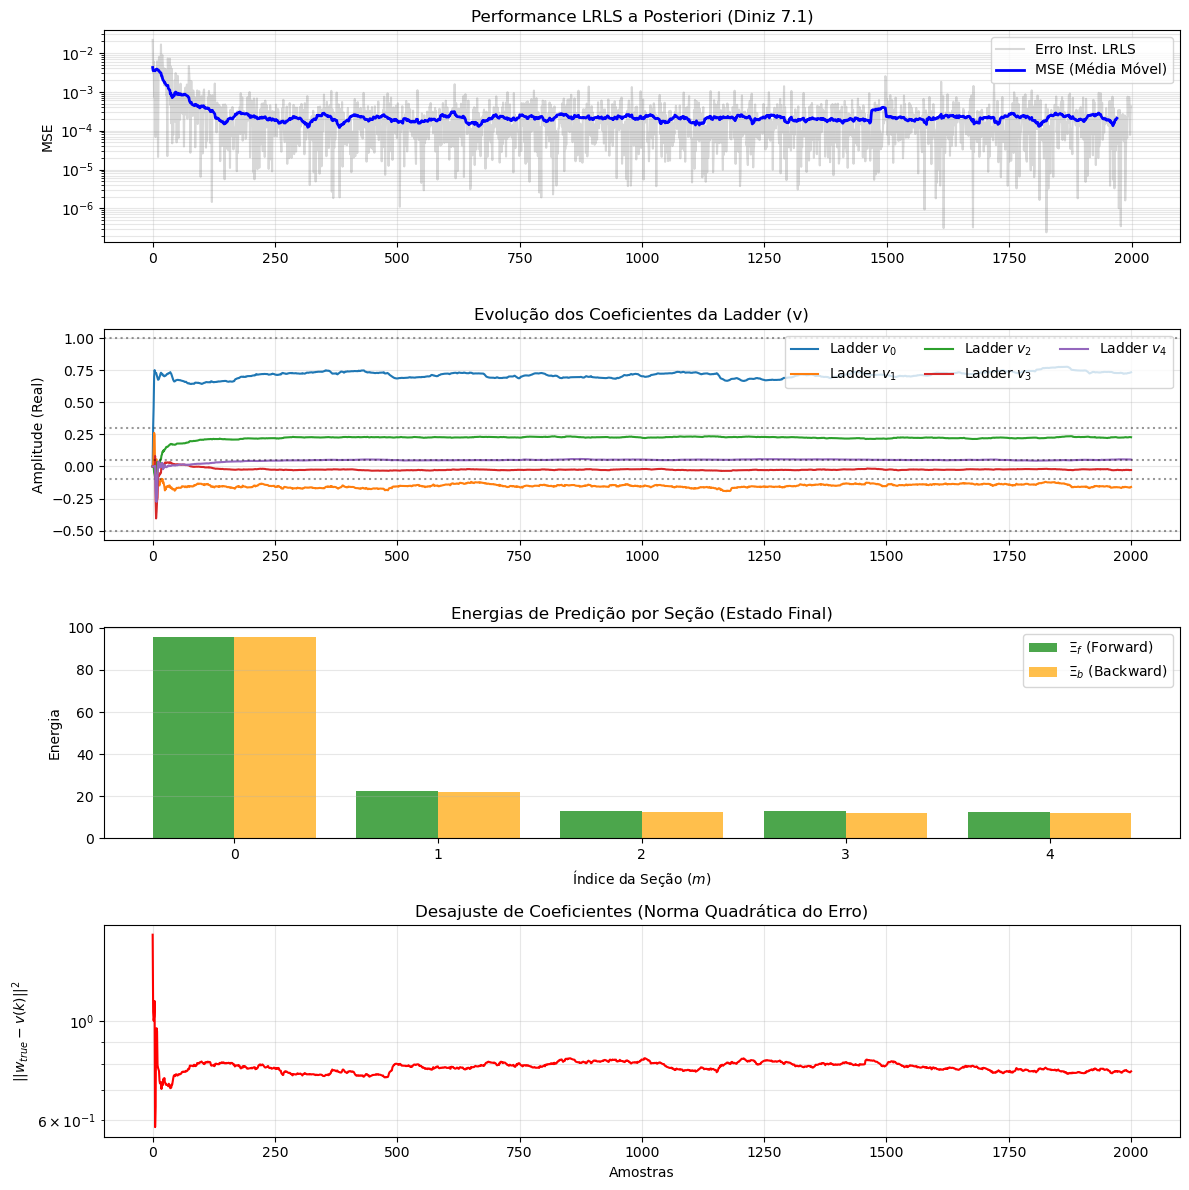

MSE Final Médio: 0.00021934


In [4]:
# --- 3. VISUALIZAÇÃO DOS RESULTADOS ---
plt.figure(figsize=(12, 12))

# Subplot 1: Erro Quadrático (MSE)
plt.subplot(4, 1, 1)
plt.semilogy(result.mse(), label='Erro Inst. LRLS', alpha=0.3, color='gray')
mse_smooth = np.convolve(result.mse(), np.ones(30)/30, mode='valid')
plt.semilogy(mse_smooth, label='MSE (Média Móvel)', color='blue', lw=2)
plt.title('Performance LRLS a Posteriori (Diniz 7.1)')
plt.ylabel('MSE')
plt.grid(True, which='both', alpha=0.3)
plt.legend()

# Subplot 2: Coeficientes da Ladder (v) - Parte Real
plt.subplot(4, 1, 2)
v_hist = np.real(result.coefficients)
for i in range(v_hist.shape[1]):
    plt.plot(v_hist[:, i], label=f'Ladder $v_{i}$')
    plt.axhline(y=np.real(w_true[i]), color='black', linestyle=':', alpha=0.4)
plt.title('Evolução dos Coeficientes da Ladder (v)')
plt.ylabel('Amplitude (Real)')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', ncol=3)

# Subplot 3: Energias Finais por Seção
plt.subplot(4, 1, 3)
xi_f = result.extra["xi_f"]
xi_b = result.extra["xi_b"]
sections = np.arange(len(xi_f))
plt.bar(sections - 0.2, xi_f, width=0.4, label=r'$\Xi_f$ (Forward)', color='green', alpha=0.7)
plt.bar(sections + 0.2, xi_b, width=0.4, label=r'$\Xi_b$ (Backward)', color='orange', alpha=0.7)
plt.title('Energias de Predição por Seção (Estado Final)')
plt.xlabel('Índice da Seção ($m$)')
plt.ylabel('Energia')
plt.legend()
plt.grid(True, axis='y', alpha=0.3)

# Subplot 4: Diferença de Coeficientes (Weight Mismatch)
plt.subplot(4, 1, 4)
mismatch = np.linalg.norm(result.coefficients - w_true, axis=1)**2
plt.semilogy(mismatch, color='red')
plt.title('Desajuste de Coeficientes (Norma Quadrática do Erro)')
plt.ylabel('$||w_{true} - v(k)||^2$')
plt.xlabel('Amostras')
plt.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"MSE Final Médio: {np.mean(result.mse()[-100:]):.8f}")